In [10]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from sklearn import set_config

set_config(transform_output = "pandas")

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

folder_path = Path('/projects/2/prjs1098/system_analytics_2024/prom_data/benchmark_single_node_job_data')

# folder_path =  Path('./system_analytics_2024/prom_data/benchmark_single_node_job_data')
benchmark_job_file= folder_path / 'benchmark_job_data_cleaned.csv'
benchmark_prom_file= folder_path / 'benchmark_job_data_with_prom.parquet.gzip'

df_benchmark_job = pd.read_csv(benchmark_job_file)
df_benchmark_prom = pd.read_parquet(benchmark_prom_file)
display(df_benchmark_job.head(), df_benchmark_prom.head())

,job_id,submit,eligible,start,end,elapsed,slurm_job_id,state,alloccpus,totalcpu,node_list,name,system,result,fail_reason,fail_phase,environment,time_compile,time_performance,time_run,time_sanity,time_setup,time_total,pref_name,pref_reference,pref_thres_lower,pref_thres_upper,pref_unit,pref_value,valid_prog_environs,valid_systems,executable,executable_opts,num_tasks,num_tasks_per_node,num_cpus_per_task,time_limit,prerun_cmds,postrun_cmds,modules,env_vars,readonly_files
0,8616980,2024-11-20T11:54:35,2024-11-20T11:54:35,2024-11-20T11:54:52,2024-11-20T12:07:43,00:12:51,8616980,COMPLETED,72,03:29:30,gcn49,GROMACS_GPU %n_gpus=1,snellius:gpu_a100,success,NaN,NaN,eb-foss,0.029076,0.227419,792.553260,0.096275,0.527797,794.377215,perf,0,NaN,NaN,ns/day,16.529,['eb-foss'],"['snellius:gpu_a100', 'snellius:gpu_h100']",gmx_mpi,['mdrun -v -pin on -dlb yes -resethway -deffnm...,1,1.0,18.0,1800.0,['cp /gpfs/work4/1/reframe0/resourcesdir/groma...,[],['gromacs-foss-gpu'],{},[]
1,8616982,2024-11-20T11:54:38,2024-11-20T11:54:38,2024-11-20T11:54:41,2024-11-20T12:07:18,00:12:37,8616982,COMPLETED,64,02:57:44,gcn149,GROMACS_GPU %n_gpus=1,snellius:gpu_h100,success,NaN,NaN,eb-foss,0.028724,0.073034,766.922158,0.097536,0.048740,770.778406,perf,0,NaN,NaN,ns/day,25.705,['eb-foss'],"['snellius:gpu_a100', 'snellius:gpu_h100']",gmx_mpi,['mdrun -v -pin on -dlb yes -resethway -deffnm...,1,1.0,16.0,1800.0,['cp /gpfs/work4/1/reframe0/resourcesdir/groma...,[],['gromacs-foss-gpu'],{},[]
2,8616984,2024-11-20T11:54:40,2024-11-20T11:54:40,2024-11-20T11:54:52,2024-11-20T12:08:01,00:13:09,8616984,COMPLETED,128,06:26:11,tcn109,GROMACS_CPU %n_cores=32,snellius:rome,success,NaN,NaN,eb-foss-mpi,0.028928,0.179587,806.839507,0.187784,0.047647,813.222719,perf,0,NaN,NaN,ns/day,3.262,['eb-foss-mpi'],"['snellius:rome', 'snellius:genoa']",gmx_mpi,['mdrun -v -pin on -dlb yes -resethway -deffnm...,32,32.0,1.0,1800.0,['cp /gpfs/work4/1/reframe0/resourcesdir/groma...,[],['gromacs-foss'],{},[]
3,8616986,2024-11-20T11:54:43,2024-11-20T11:54:43,2024-11-20T11:54:52,2024-11-20T12:07:56,00:13:04,8616986,COMPLETED,192,06:29:00,tcn575,GROMACS_CPU %n_cores=32,snellius:genoa,success,NaN,NaN,eb-foss-mpi,0.029197,0.046268,798.165663,0.052712,0.047641,806.888496,perf,0,NaN,NaN,ns/day,3.343,['eb-foss-mpi'],"['snellius:rome', 'snellius:genoa']",gmx_mpi,['mdrun -v -pin on -dlb yes -resethway -deffnm...,32,32.0,1.0,1800.0,['cp /gpfs/work4/1/reframe0/resourcesdir/groma...,[],['gromacs-foss'],{},[]
4,8617011,2024-11-20T11:57:08,2024-11-20T11:57:08,2024-11-20T11:57:22,2024-11-20T12:02:20,00:04:58,8617011,COMPLETED,128,08:15:03,tcn111,HPCG_MPIOnly %nnodes=1,snellius:rome,success,NaN,NaN,eb-foss-mpi,120.110956,0.027074,318.363357,0.167167,0.051292,472.052970,gflops,0,NaN,NaN,Gflop/s,37.848,"['eb-foss-mpi', 'eb-intel-mpi']","['lisa:silver', 'lisa:gold', 'snellius:rome', ...",hpcg/bin/xhpcg,"['--nx=104', '--ny=104', '--nz=104', '-t2']",128,128.0,1.0,3600.0,[],[],[],{},[]


,job_id,node,rack,timestamp,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_core_throttles_total_min,node_cpu_core_throttles_total_max,node_cpu_core_throttles_total_mean,node_cpu_core_throttles_total_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_cpu_package_throttles_total_min,node_cpu_package_throttles_total_max,node_cpu_package_throttles_total_mean,node_cpu_package_throttles_total_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_power_average_interval_max_seconds_min,node_hwmon_power_average_interval_max_seconds_max,node_hwmon_power_average_interval_max_seconds_mean,node_hwmon_power_average_interval_max_seconds_median,node_hwmon_power_average_interval_min_seconds_min,node_hwmon_power_average_interval_min_seconds_max,node_hwmon_power_average_interval_min_seconds_mean,node_hwmon_power_average_interval_min_seconds_median,node_hwmon_power_average_interval_seconds_min,node_hwmon_power_average_interval_seconds_max,node_hwmon_power_average_interval_seconds_mean,node_hwmon_power_average_interval_seconds_median,node_hwmon_power_average_watt_min,node_hwmon_power_average_watt_max,node_hwmon_power_average_watt_mean,node_hwmon_power_average_watt_median,node_hwmon_power_is_battery_watt_min,node_hwmon_power_is_battery_watt_max,node_hwmon_power_is_battery_watt_mean,node_hwmon_power_is_battery_watt_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_me

In [12]:
"""   
If we need to change the mapping from name to class, here we can also do it.
"""
mapping_name_to_class = {'HPCG_MPIOnly %nnodes=1':'memory_intensive',
                        'Palabos_CPU_WS %nnodes=1 %ppn=full':'memory_intensive',
                         'Cp2k_Cpu %nnodes=1':'high_CPU',
                         'HemePure_CPU_SS_small %nnodes=1 %ppn=full':'memory_intensive',
                        'HemePure_CPU_SS_small %nnodes=1 %ppn=half':'memory_intensive_half',
                        'GROMACS_CPU %n_cores=32':'high_CPU',
                        'GROMACS_GPU %n_gpus=1':'high_CPU_GPU'               
    }
df_benchmark_job['class'] = df_benchmark_job['name'].apply(lambda x: mapping_name_to_class[x])


display(df_benchmark_job['name'].value_counts(),
        df_benchmark_job['environment'].value_counts(),
        df_benchmark_job['class'].value_counts()
        )
# Set the distingusher here
distinguisher = 'class'

name
HPCG_MPIOnly %nnodes=1                       54
Palabos_CPU_WS %nnodes=1 %ppn=full           32
Cp2k_Cpu %nnodes=1                           30
HemePure_CPU_SS_small %nnodes=1 %ppn=full    30
HemePure_CPU_SS_small %nnodes=1 %ppn=half    30
GROMACS_CPU %n_cores=32                      22
GROMACS_GPU %n_gpus=1                        22
Name: count, dtype: int64

environment
eb-foss         114
eb-foss-mpi      85
eb-intel-mpi     21
Name: count, dtype: int64

class
memory_intensive         116
high_CPU                  52
memory_intensive_half     30
high_CPU_GPU              22
Name: count, dtype: int64

In [13]:
prom_selected_signals = ['job_id',
 'node_load1_mean',
 'node_load15_mean',
 'node_load5_mean',
 'node_cpu_core_throttles_total_mean',
'node_cpu_frequency_hertz_mean', 
'node_filesystem_files_mean',
'node_cpu_frequency_max_hertz_mean',
 'node_cpu_frequency_min_hertz_mean',
 'node_cpu_package_throttles_total_mean',
 'node_disk_io_now_mean',
 'node_disk_read_bytes_total_mean',
 'node_disk_writes_completed_total_mean',
 'node_disk_written_bytes_total_mean',
 'node_filesystem_avail_bytes_mean',
 'node_filesystem_files_free_mean',
 'node_filesystem_free_bytes_mean',
  'node_network_receive_bytes_total_mean',
 'node_network_receive_drop_total_mean',
 'node_network_receive_multicast_total_mean',
 'node_network_receive_packets_total_mean',
 'node_network_transmit_bytes_total_mean',
 'node_network_transmit_packets_total_mean',
'node_procs_blocked_mean',
 'node_memory_MemAvailable_bytes_mean',
 'node_memory_MemFree_bytes_mean',
 'node_memory_MemTotal_bytes_mean',
 'node_memory_Percpu_bytes_mean',
 'node_procs_running_mean',
 'node_rapl_core_joules_total_mean',
 'node_rapl_dram_joules_total_mean',
 'node_rapl_package_joules_total_mean',
 'surf_ambient_temp_mean',
 'surf_confluent_mean',
 'surf_cpu_power_mean',
 'surf_exhaust_temp_mean',
 'surf_gpu_board_power_mean',
 'surf_inlet_water_temp_mean',
 'surf_mem_power_mean',
 'surf_sys_power_mean',
 'surf_temp_cpu_mean',
 'surf_virtual_mean']


df_benchmark_prom = df_benchmark_prom[prom_selected_signals].copy()

df_benchmark_prom.head()


,job_id,node_load1_mean,node_load15_mean,node_load5_mean,node_cpu_core_throttles_total_mean,node_cpu_frequency_hertz_mean,node_filesystem_files_mean,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_min_hertz_mean,node_cpu_package_throttles_total_mean,node_disk_io_now_mean,node_disk_read_bytes_total_mean,node_disk_writes_completed_total_mean,node_disk_written_bytes_total_mean,node_filesystem_avail_bytes_mean,node_filesystem_files_free_mean,node_filesystem_free_bytes_mean,node_network_receive_bytes_total_mean,node_network_receive_drop_total_mean,node_network_receive_multicast_total_mean,node_network_receive_packets_total_mean,node_network_transmit_bytes_total_mean,node_network_transmit_packets_total_mean,node_procs_blocked_mean,node_memory_MemAvailable_bytes_mean,node_memory_MemFree_bytes_mean,node_memory_MemTotal_bytes_mean,node_memory_Percpu_bytes_mean,node_procs_running_mean,node_rapl_core_joules_total_mean,node_rapl_dram_joules_total_mean,node_rapl_package_joules_total_mean,surf_ambient_temp_mean,surf_confluent_mean,surf_cpu_power_mean,surf_exhaust_temp_mean,surf_gpu_board_power_mean,surf_inlet_water_temp_mean,surf_mem_power_mean,surf_sys_power_mean,surf_temp_cpu_mean,surf_virtual_mean
0,8616980,3.25,4.36,3.46,0.0,2.400000e+09,47289461.0,2.400000e+09,800000000.0,0.0,0.0,853950464.0,60091.333333,5.547607e+10,1.924615e+11,4.728587e+07,1.924615e+11,6.115282e+11,3.0,2.388704e+07,2.972705e+08,1.886971e+10,5.682068e+07,0.0,4.995814e+11,4.829182e+11,5.406354e+11,83558400.0,3.0,NaN,47905.479392,134403.584667,33.0,1.0,250.0,33.0,950.0,NaN,28.0,990.0,45.5,0.0
1,8616980,3.25,4.36,3.46,0.0,2.400000e+09,47289461.0,2.400000e+09,800000000.0,0.0,0.0,853950464.0,60091.333333,5.547607e+10,1.924615e+11,4.728587e+07,1.924615e+11,6.115282e+11,3.0,2.388704e+07,2.972705e+08,1.886971e+10,5.682068e+07,0.0,4.995814e+11,4.829182e+11,5.406354e+11,83558400.0,3.0,NaN,47905.479392,134403.584667,33.0,1.0,250.0,33.0,950.0,NaN,28.0,990.0,45.5,0.0
2,8616980,3.25,4.36,3.46,0.0,2.400000e+09,47289461.0,2.400000e+09,800000000.0,0.0,0.0,853950464.0,60091.333333,5.547607e+10,1.924615e+11,4.728587e+07,1.924615e+11,6.115282e+11,3.0,2.388704e+07,2.972705e+08,1.886971e+10,5.682068e+07,0.0,4.995814e+11,4.829182e+11,5.406354e+11,83558400.0,3.0,NaN,47905.479392,134403.584667,33.0,1.0,250.0,33.0,950.0,NaN,28.0,990.0,45.5,0.0
3,8616980,3.10,4.30,3.45,0.0,2.400000e+09,47289461.0,2.400000e+09,800000000.0,0.0,0.0,853950464.0,60091.333333,5.547607e+10,1.924615e+11,4.728587e+07,1.924615e+11,6.115282e+11,3.0,2.388745e+07,2.972712e+08,1.886973e+10,5.682077e+07,0.0,4.995741e+11,4.829109e+11,5.406354e+11,83558400.0,3.0,NaN,48742.138182,141927.105659,33.0,1.0,250.0,33.0,950.0,NaN,28.0,990.0,45.5,0.0
4,8616980,3.10,4.30,3.45,0.0,2.400000e+09,47289461.0,2.400000e+09,800000000.0,0.0,0.0,853950464.0,60091.333333,5.547607e+10,1.924615e+11,4.728587e+07,1.924615e+11,6.115282e+11,3.0,2.388745e+07,2.972712e+08,1.886973e+10,5.682077e+07,0.0,4.995741e+11,4.829109e+11,5.406354e+11,83558400.0,3.0,NaN,48742.138182,141927.105659,33.0,1.0,250.0,33.0,950.0,NaN,28.0,990.0,45.5,0.0


In [14]:
# get some statistics for the a signal
df_benchmark_prom_stat = df_benchmark_prom.groupby('job_id', as_index=False).agg(['min', 'mean', 'max'])

# Rename columns
df_benchmark_prom_stat.columns = [
    f"{agg}_{col}" for col, agg in df_benchmark_prom_stat.columns
]

df_benchmark_prom_stat.rename(columns={"_job_id":"job_id"}, inplace=True)
# drop the columns that are all nan. No information there.
df_benchmark_prom_stat.dropna(axis=1, how='all', inplace=True)
df_benchmark_prom_stat = df_benchmark_prom_stat.select_dtypes(exclude='object')

# merge it with the df_benchmark
df_job_stat = pd.merge(df_benchmark_job[['job_id', distinguisher]], df_benchmark_prom_stat, on='job_id')
df_job_stat.head()


,job_id,class,min_node_load1_mean,mean_node_load1_mean,max_node_load1_mean,min_node_load15_mean,mean_node_load15_mean,max_node_load15_mean,min_node_load5_mean,mean_node_load5_mean,max_node_load5_mean,min_node_cpu_core_throttles_total_mean,mean_node_cpu_core_throttles_total_mean,max_node_cpu_core_throttles_total_mean,min_node_cpu_frequency_hertz_mean,mean_node_cpu_frequency_hertz_mean,max_node_cpu_frequency_hertz_mean,min_node_filesystem_files_mean,mean_node_filesystem_files_mean,max_node_filesystem_files_mean,min_node_cpu_frequency_max_hertz_mean,mean_node_cpu_frequency_max_hertz_mean,max_node_cpu_frequency_max_hertz_mean,min_node_cpu_frequency_min_hertz_mean,mean_node_cpu_frequency_min_hertz_mean,max_node_cpu_frequency_min_hertz_mean,min_node_cpu_package_throttles_total_mean,mean_node_cpu_package_throttles_total_mean,max_node_cpu_package_throttles_total_mean,min_node_disk_io_now_mean,mean_node_disk_io_now_mean,max_node_disk_io_now_mean,min_node_disk_read_bytes_total_mean,mean_node_disk_read_bytes_total_mean,max_node_disk_read_bytes_total_mean,min_node_disk_writes_completed_total_mean,mean_node_disk_writes_completed_total_mean,max_node_disk_writes_completed_total_mean,min_node_disk_written_bytes_total_mean,mean_node_disk_written_bytes_total_mean,max_node_disk_written_bytes_total_mean,min_node_filesystem_avail_bytes_mean,mean_node_filesystem_avail_bytes_mean,max_node_filesystem_avail_bytes_mean,min_node_filesystem_files_free_mean,mean_node_filesystem_files_free_mean,max_node_filesystem_files_free_mean,min_node_filesystem_free_bytes_mean,mean_node_filesystem_free_bytes_mean,max_node_filesystem_free_bytes_mean,min_node_network_receive_bytes_total_mean,mean_node_network_receive_bytes_total_mean,max_node_network_receive_bytes_total_mean,min_node_network_receive_drop_total_mean,mean_node_network_receive_drop_total_mean,max_node_network_receive_drop_total_mean,min_node_network_receive_multicast_total_mean,mean_node_network_receive_multicast_total_mean,max_node_network_receive_multicast_total_mean,min_node_network_receive_packets_total_mean,mean_node_network_receive_packets_total_mean,max_node_network_receive_packets_total_mean,min_node_network_transmit_bytes_total_mean,mean_node_network_transmit_bytes_total_mean,max_node_network_transmit_bytes_total_mean,min_node_network_transmit_packets_total_mean,mean_node_network_transmit_packets_total_mean,max_node_network_transmit_packets_total_mean,min_node_procs_blocked_mean,mean_node_procs_blocked_mean,max_node_procs_blocked_mean,min_node_memory_MemAvailable_bytes_mean,mean_node_memory_MemAvailable_bytes_mean,max_node_memory_MemAvailable_bytes_mean,min_node_memory_MemFree_bytes_mean,mean_node_memory_MemFree_bytes_mean,max_node_memory_MemFree_bytes_mean,min_node_memory_MemTotal_bytes_mean,mean_node_memory_MemTotal_bytes_mean,max_node_memory_MemTotal_bytes_mean,min_node_memory_Percpu_bytes_mean,mean_node_memory_Percpu_bytes_mean,max_node_memory_Percpu_bytes_mean,min_node_procs_running_mean,mean_node_procs_running_mean,max_node_procs_running_mean,min_node_rapl_core_joules_total_mean,mean_node_rapl_core_joules_total_mean,max_node_rapl_core_joules_total_mean,min_node_rapl_dram_joules_total_mean,mean_node_rapl_dram_joules_total_mean,max_node_rapl_dram_joules_total_mean,min_node_rapl_package_joules_total_mean,mean_node_rapl_package_joules_total_mean,max_node_rapl_package_joules_total_mean,min_surf_ambient_temp_mean,mean_surf_ambient_temp_mean,max_surf_ambient_temp_mean,min_surf_confluent_mean,mean_surf_confluent_mean,max_surf_confluent_mean,min_surf_cpu_power_mean,mean_surf_cpu_power_mean,max_surf_cpu_power_mean,min_surf_exhaust_temp_mean,mean_surf_exhaust_temp_mean,max_surf_exhaust_temp_mean,min_surf_gpu_board_power_mean,mean_surf_gpu_board_power_mean,max_surf_gpu_board_power_mean,min_surf_inlet_water_temp_mean,mean_surf_inlet_water_temp_mean,max_surf_inlet_water_temp_mean,min_surf_mem_power_mean,mean_surf_mem_power_mean,max_surf_mem_power_mean,min_surf_sys_power_mean,mean_surf_sys_power_mean,max_s

In [15]:
# drop signals that we dont want
df_job_stat.drop(labels=['job_id'], axis=1, inplace=True)

# X, y
X = df_job_stat.drop(labels=[distinguisher], axis=1).copy()
y = df_job_stat[[distinguisher]]

# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y.values)


In [16]:
"""   
Preprocessing the data
"""
# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

/gpfs/home4/teimourh/energy_efficiency_job_level/.surfdb/lib64/python3.9/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/gpfs/home4/teimourh/energy_efficiency_job_level/.surfdb/lib64/python3.9/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy: 0.5455
Confusion Matrix:
[[ 0  0  5  0]
 [ 0  0  2  0]
 [ 0  0 12  0]
 [ 0  0  3  0]]


<Axes: >

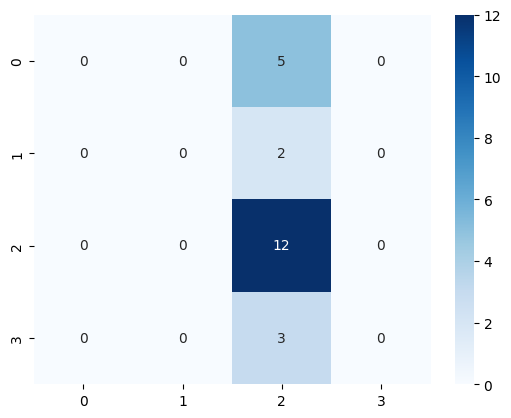

In [17]:
"""   
train a dummy classifier...
"""

model = DummyClassifier(strategy="most_frequent")

# Train the model
model.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_encoded = model.predict(X_test)

# Decode predictions back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


/gpfs/home4/teimourh/energy_efficiency_job_level/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:43:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/energy_efficiency_job_level/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:43:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/energy_efficiency_job_level/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:43:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/gpfs/home4/teimourh/energy_efficiency_job_level/.surfdb/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:43:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


Best Model Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validated Accuracy: 0.6071
Accuracy: 0.5909
Confusion Matrix:


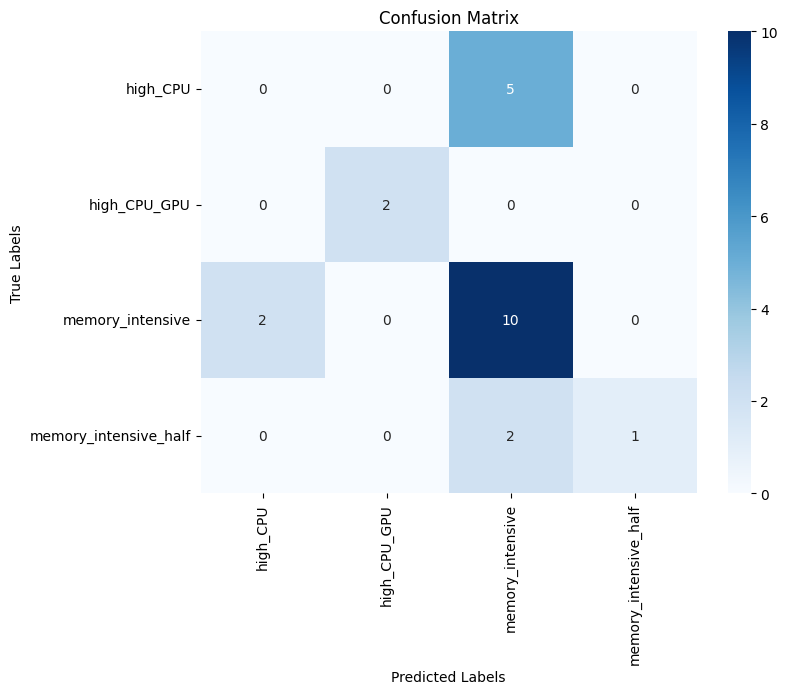

In [18]:


# Define parameter grid for XGBClassifier
param_grid = {
    "n_estimators": [5, 10, 50, 100, 200],
    "max_depth": [2, 3, 5, 7, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    "colsample_bytree": [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
}


# Initialize Stratified K-Fold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

# Initialize GridSearchCV
xgb = XGBClassifier(objective="binary:logistic", random_state=None, use_label_encoder=False, eval_metric="logloss")
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring="accuracy", 
                           cv=stratified_kfold, n_jobs=-1, verbose=1)

# Perform grid search
grid_search.fit(X_train, y_train_encoded)

# Best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Model Parameters:", best_params)
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")


# Predict on the test set
y_pred_encoded = best_model.predict(X_test)

# Decode predictions back to original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
print("Confusion Matrix:")
cf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# xgb.plot_importance(best_model, ax=ax, max_num_features=10)